In [62]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import csv

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import normalize

def gridSearch(model, parameters, x, y):
    scorer = make_scorer(mean_squared_error)
    model = GridSearchCV(model, param_grid=parameters, scoring=scorer)
    #model = grid.fit(x, y)
    print("Best score: ", model.best_score_)
    print("Best parameters for search: ", model.best_params_)
    return model

def randomSearch(model, parameters, x, y):
    scorer = make_scorer(mean_squared_error)
    model = RandomizedSearchCV(model, scoring=scorer, param_distributions=parameters)
    #model = rSearch.fit(x, y)
    print("Best score: ", model.best_score_)
    print("Best parameters: ", model.best_params_)
    return model

def plotResults(x, y, x_label, y_label, title):
    plt.scatter(x, y)
    plt.title(title, fontsize=18)
    plt.xlabel(x_label, fontsize=16)
    plt.ylabel(y_label, fontsize=16)
    plt.grid('on')
    title+=".png"
    path = "graphs_beta"
    path += title
    plt.savefig(path)

def getRasterMean(path):
    with rasterio.open(path) as raster:
        raster_data = raster.read(1)
        mean_value = raster_data.mean()
    return mean_value

def getRasterMeanDifference(path_before, path_after):
    with rasterio.open(path_before) as raster:
        raster_data = raster.read(1)
        mean_before = raster_data.mean()
    with rasterio.open(path_after) as raster:
        raster_data = raster.read(1)
        mean_after = raster_data.mean()
    return mean_before - mean_after

def plotRaster(path):
    with rasterio.open(path) as raster:
        raster_data = raster.read(1)
        plt.imshow(raster_data, cmap='Greens')
        plt.colorbar(label='Pixel values')
        plt.title(label=path)
        plt.show()

Before Mean:  0.017967729


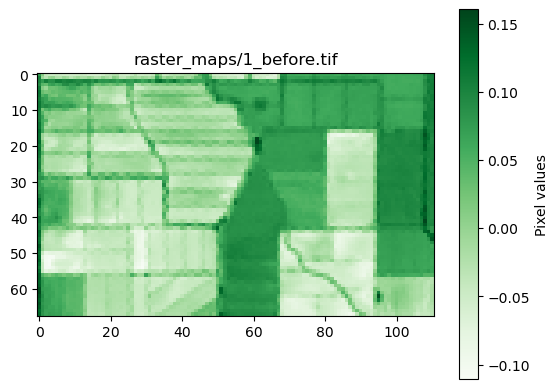

After Mean:  0.019178774


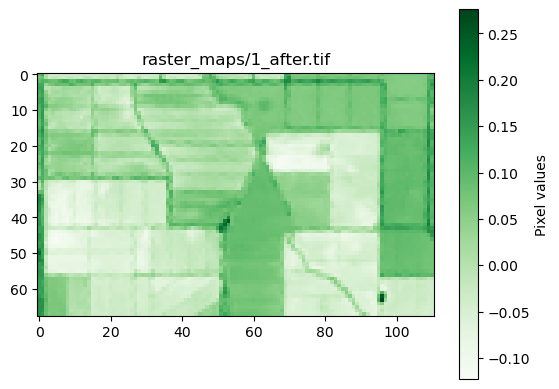

Raster data has been written to raster.csv


In [63]:
raster_file_path = 'raster_maps/1_before.tif'
print("Before Mean: ", getRasterMean(raster_file_path))
plotRaster(raster_file_path)

raster_file_path = 'raster_maps/1_after.tif'
print("After Mean: ", getRasterMean(raster_file_path))
plotRaster(raster_file_path)

with rasterio.open(raster_file_path) as raster:
    raster_data = raster.read(1)
    data_list = raster_data.tolist()

csv_output_path = 'raster.csv'

# Write the list of lists to the CSV file
with open(csv_output_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerows(data_list)

print(f'Raster data has been written to {csv_output_path}')


In [72]:
x_nvdi = np.zeros([13])
y_data = np.zeros([13])

x_precipitation = np.loadtxt("./other_data/precipitation.csv", delimiter=",", dtype=int)

for i in range(0, 13):
    path_before = 'raster_maps/' + str(i) + '_before.tif'
    print(path_before)
    path_after = 'raster_maps/' + str(i) + '_after.tif'
    x_nvdi[i] = getRasterMean(path_before)
    y_data[i] = getRasterMeanDifference(path_before, path_after)
    

raster_maps/0_before.tif
raster_maps/1_before.tif
raster_maps/2_before.tif
raster_maps/3_before.tif
raster_maps/4_before.tif
raster_maps/5_before.tif
raster_maps/6_before.tif
raster_maps/7_before.tif
raster_maps/8_before.tif
raster_maps/9_before.tif
raster_maps/10_before.tif
raster_maps/11_before.tif
raster_maps/12_before.tif


In [ ]:
print(x_nvdi)
print(x_precipitation)
print(y_data)

plotResults(x_nvdi, y_data, "nvdi before", "vegitation lost", "nvdi vs vegetation lost")

In [ ]:
plotResults(x_precipitation, y_data, "precipitation", "vegetation lost", "precipitation vs vegetation lost")

In [4]:
#data processing here
header, raw_data = np.vsplit(data, [1])
raw_x, raw_y = np.hsplit(raw_data, [2])
raw_x_veg, raw_x_rain = np.hsplit(raw_x, [1])
data_train, data_test = train_test_split(raw_data, test_size=0.20)
x_test, y_test = np.hsplit(data_test, [2])
x_train, y_train = np.hsplit(data_train, [2])

In [ ]:
plotResults(raw_x_veg, raw_y, "Prior Vegitation", "Vegitation Lost", "Prior Vegitation vs Vegitation Lost")
plotResults(raw_x_rain, raw_y, "Precipitation", "Vegitation Lost", "Precipitation vs Vegitation Lost")

In [ ]:
cValues = np.logspace(-3, 3, 7, dtype=float)
parameters = {"c": cValues}
svr = SVR(kernel="linear")
svrLinearModel = gridSearch(svr, parameters, x_train, y_train)

In [ ]:
mean_scores = svrLinearModel.cv_results_['mean_test_score']
mean_scores = np.delete(mean_scores, [0,1])
x_cValues = np.delete(cValues, [0,1])
plotResults(x_cValues, mean_scores, "c values", "Scores", "Linear: c values vs mean score")

In [ ]:
cValues = np.logspace(-3, 3, 7, dtype=float)
degrees = [2, 3, 4, 5]
parameters = {"c": cValues, "degree": degrees}
svr = SVR(kernel="poly")
svrPolyModel = gridSearch(svr, parameters, x_train, y_train)

In [ ]:
mean_scores = svrLinearModel.cv_results_['mean_test_score']
mean_scores = np.delete(mean_scores, [0,1])
x_cValues = np.delete(cValues, [0,1])
plotResults(x_cValues, mean_scores, "c values", "Scores", "Polynomial: c values vs mean score")